In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

In [2]:
# 맷플롯립 한글 사용 가능
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 2. 동별 버스정류장 갯수

### 2-1. 서울시 동 경계 데이터 확인

In [3]:
dong_gdf = gpd.read_file \
    ('../4.Public_transportation/BND_ADM_DONG_PG_dong/BND_ADM_DONG_PG.shp', encoding="CP949")

# 데이터 기본 정보 확인
print("데이터 형태:", dong_gdf.shape)
print("/n컬럼 목록:")
print(dong_gdf.columns)

# 처음 몇 행 출력
print("/n데이터 미리보기:")
print(dong_gdf.head())

# 좌표계 정보
print("/n좌표계 정보:")
print(dong_gdf.crs)

# 지리적 범위
print("/n지리적 범위:")
print(dong_gdf.total_bounds)

데이터 형태: (3528, 4)
/n컬럼 목록:
Index(['BASE_DATE', 'ADM_NM', 'ADM_CD', 'geometry'], dtype='object')
/n데이터 미리보기:
  BASE_DATE ADM_NM    ADM_CD  \
0  20230701    사직동  11010530   
1  20230701    삼청동  11010540   
2  20230701    부암동  11010550   
3  20230701    평창동  11010560   
4  20230701    한남동  11030740   

                                            geometry  
0  POLYGON ((197702.069 553187.311, 197703.431 55...  
1  POLYGON ((198170.457 553770.678, 198172.189 55...  
2  POLYGON ((196621.023 556395.880, 196628.323 55...  
3  POLYGON ((197800.719 559064.245, 197782.581 55...  
4  POLYGON ((200404.268 550031.323, 200404.019 55...  
/n좌표계 정보:
PROJCS["Korea_2000_Korea_Central_Belt_2010",GEOGCS["GCS_Korea_2000",DATUM["Korean_Geodetic_Datum_2002",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6737"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",127],PA

### 2-2 데이터 불러오기

In [4]:
# 동 경계 데이터 불러오기
dong_gdf = gpd.read_file \
    ('../4.Public_transportation/BND_ADM_DONG_PG_dong/BND_ADM_DONG_PG.shp', encoding="CP949")

In [5]:
# 버스 정류소 좌표 데이터 읽기
bus_stops = pd.read_csv('../4.Public_transportation/Bus_stop_latitude_and_longitude.csv')

### 2-3. 버스정류소 데이터를 GeoDataFrame으로 변환

In [6]:
# Point 객체로 변환
bus_stops['geometry'] = bus_stops.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)

# GeoDataFrame 생성 (WGS 84 좌표계)
bus_stops_gdf = gpd.GeoDataFrame(bus_stops, geometry='geometry', crs="EPSG:4326")

# 좌표계를 동 경계 데이터에 맞춤 (Korea Central Belt 2010)
bus_stops_gdf = bus_stops_gdf.to_crs(dong_gdf.crs)


### 2-4. Spatial Join을 통한 동별 할당

In [7]:
# Spatial Join
joined = gpd.sjoin(bus_stops_gdf, dong_gdf, how="inner", op="within")

# 동별 버스정류소 개수 계산
dong_bus_counts = joined.groupby('ADM_NM').size().reset_index(name='Bus_Stop_Count')

# 결과 확인
print(dong_bus_counts)

    ADM_NM  Bus_Stop_Count
0     가락1동              14
1     가락2동              21
2     가락본동              25
3     가리봉동               9
4      가산동             105
..     ...             ...
428    효창동              15
429    후암동              18
430   휘경1동              14
431   휘경2동              17
432    흑석동              48

[433 rows x 2 columns]


c:\Users\human\.conda\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


### 2-5. 결과 시각화

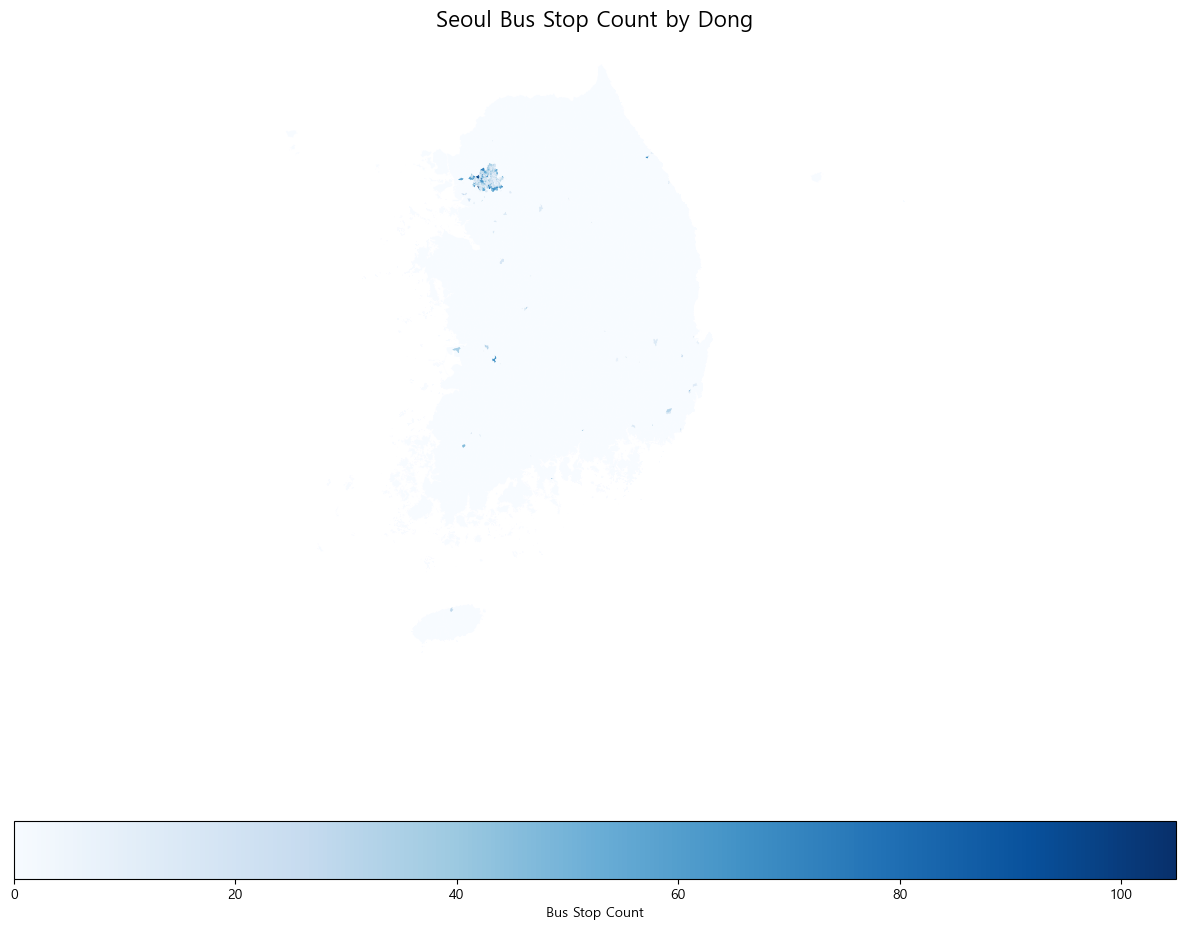

In [8]:
# 동 경계 데이터에 정류소 개수 병합
dong_gdf = dong_gdf.merge(dong_bus_counts, how="left", left_on="ADM_NM", right_on="ADM_NM")
dong_gdf['Bus_Stop_Count'] = dong_gdf['Bus_Stop_Count'].fillna(0)  # 정류소가 없는 경우 0으로 대체

# 지도 시각화
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
dong_gdf.plot(column='Bus_Stop_Count', ax=ax, legend=True, cmap='Blues',
              legend_kwds={'label': "Bus Stop Count", 'orientation': "horizontal"})
ax.set_title("Seoul Bus Stop Count by Dong", fontsize=16)
ax.axis('off')
plt.show()


### 2-6. 결과 저장

In [9]:
dong_bus_counts.to_csv('Data_Preprocessing/4_Bus_stop_counts_by_dong.csv', index=False)
